In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
#Read in data
image_data = pd.read_csv("image_data.csv")

# PCA

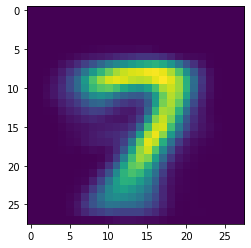

In [257]:
#Compute the mean image
mu = np.mean(image_data, axis = 0)

images_centered = image_data - mu

#Reshape the mean image to 28x28
mu_image = mu.values.reshape(28, 28)

#Plot the mean image
plt.imshow(mu_image)
plt.show()

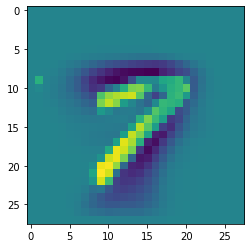

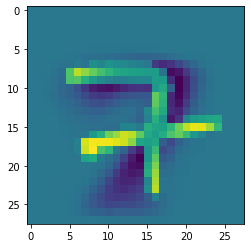

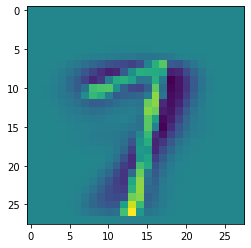

In [258]:
#Plot 5 images
for x in range(3):
    plt.imshow(images_centered.iloc[x].values.reshape(28, 28))
    plt.show()

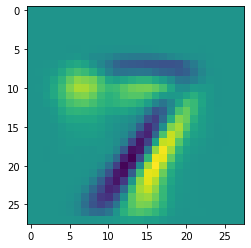

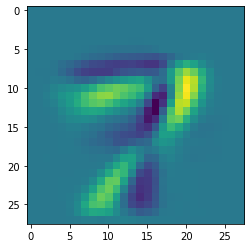

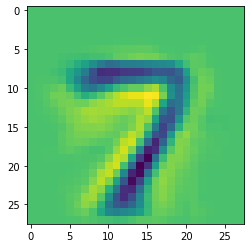

In [259]:
#Find covariance matrix
cov_matrix = np.cov(images_centered, rowvar = False)

#Find eigenvalues/eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

#Sort eigenvalues and eigenvectors in descending order
index = np.argsort(eigenvalues)[::-1]
eigenvalues_sort = np.real(eigenvalues[index])
eigenvectors_sort = np.real(eigenvectors[:, index])

#Plot eigen
for i in range(3):
    eigenvector = eigenvectors_sort[:, i].reshape(28, 28)
    plt.imshow(eigenvector)
    plt.show()

In [261]:
eigenvector25 = eigenvectors_sort[:, :25]
eigenvector25_norm = eigenvector25 / np.linalg.norm(eigenvector25, axis = 0)

#Find z
z = np.dot(images_centered, eigenvector25_norm)

for i in range(3):
    print(z[i])

[-1.03136527  0.35326307  4.01789278  0.27050322  0.59971823 -1.55447652
 -0.2552432   0.10232433  0.19182115  2.97658169 -0.82979264 -0.52570768
 -0.20050516  0.28039968  0.26677761  0.18271454 -0.89525454  0.21332124
 -0.77339384  0.74364718 -0.91515695  0.21270614  0.02733942  0.11974364
 -0.18001764]
[ 0.78079059 -3.33386314  0.74446257 -1.37104463  1.25322514  0.66703559
  0.79573746  0.46595839 -0.76079171 -0.70082282 -2.24109946  0.98100613
 -0.03296597  0.30013884 -1.21397938 -0.08352247  0.11144206  0.25859501
 -0.06444977 -0.11301512 -1.43553206  0.03709865 -1.23311407 -0.50975447
 -0.63685209]
[ 0.18439129 -2.34851269  1.32231903  1.33988419 -1.23793722 -1.17582102
 -1.57018091  1.97747768 -0.21323937 -0.99741949  0.78197579  0.06079915
 -0.16139374  0.03203509  0.44460467  0.36329856  0.32011187  0.30028009
  0.82557877  0.00838552  0.12369397 -0.32791118 -0.07301005  0.33084265
 -0.16480031]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


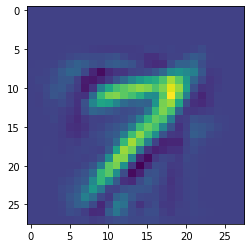

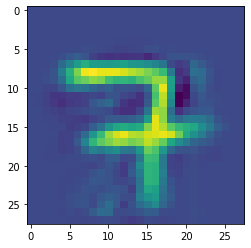

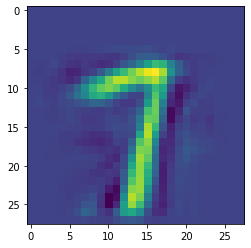

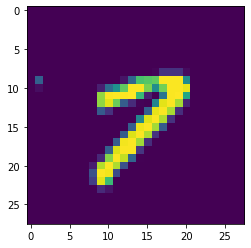

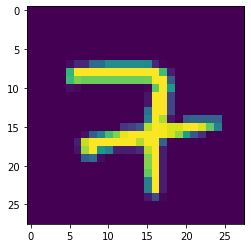

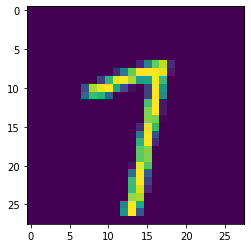

In [276]:
mu_image_1d = mu_image.reshape(1, -1)

#Reconstruct images
reconstructed = np.dot(z, eigenvector25_norm.T) + mu_image_1d

for i in range(3):
    plt.imshow(reconstructed[i].reshape(28, 28))
    plt.show()
    
for i in range(3):
    plt.imshow(image_data.iloc[i].values.reshape(28, 28))
    plt.show()

# Linear Autoencoder

In [16]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim, dtype = torch.float64)

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim, dtype = torch.float64)

    def forward(self, z):
        z = self.fc(z)
        return z

#Define parameters
input_dim = 28 * 28  #Size 28x28
output_dim = 25

#Initialize encoder and decoder
encoder = Encoder(input_dim, output_dim)
decoder = Decoder(output_dim, input_dim)


In [17]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

lr = 0.001
batch_size = 3
epochs = 10

class Dataset(Dataset):
    def __init__(self, csv_file, transform = None):
        self.data = pd.read_csv(csv_file, dtype = "float64")
        self.transform = transform
        
        scaler = MinMaxScaler()
        self.data = scaler.fit_transform(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

csv_file = 'image_data.csv'

#Data to tensors
transform = torch.tensor

#Data
dataset = Dataset(csv_file, transform = transform)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [18]:
import torch.optim as optim

#Optimizer and Loss
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = lr)

#Train
for epoch in range(epochs):
    running_loss = 0.0
    for data in data_loader:
        inputs = data 
        optimizer.zero_grad()
        encoded = encoder(inputs)
        decoded = decoder(encoded)
        loss = criterion(decoded, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader)}")

Epoch [1/10], Loss: 0.06303511925202096
Epoch [2/10], Loss: 0.03761883416036469
Epoch [3/10], Loss: 0.029538183099227053
Epoch [4/10], Loss: 0.025920426864627415
Epoch [5/10], Loss: 0.023833034344788926
Epoch [6/10], Loss: 0.022350608875788547
Epoch [7/10], Loss: 0.021040951263442947
Epoch [8/10], Loss: 0.019959886027195468
Epoch [9/10], Loss: 0.019067706400504883
Epoch [10/10], Loss: 0.018194894865879968


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images:


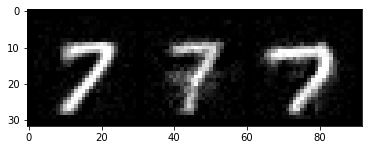

In [19]:
import torchvision

#Display image function
def imshow(image):     
    image = image.numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

images = next(iter(data_loader))

with torch.no_grad():
    encoded_images = encoder(images)
    reconstructed_images = decoder(encoded_images)

#Reconstructed images
print('Reconstructed Images:')
imshow(torchvision.utils.make_grid(reconstructed_images.view(batch_size, 1, 28, 28)))

# Non-Linear Autoencoder

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128, dtype = torch.float64)  #Linear layer 1
        self.fc2 = nn.Linear(128, output_dim, dtype = torch.float64) #Linear layer 2
        self.relu = nn.ReLU()  #ReLU activation function

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.relu(self.fc1(x))  #Apply ReLU activation after first linear layer
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128, dtype = torch.float64)  #Linear layer 1
        self.fc2 = nn.Linear(128, output_dim, dtype = torch.float64) #Linear layer 2
        self.sigmoid = nn.Sigmoid()  #Sigmoid activation function

    def forward(self, z):
        z = self.fc1(z)
        z = self.sigmoid(self.fc2(z))  #Sigmoid activation
        return z

#Parameters
input_dim = 28 * 28  #Size 28x28
output_dim = 25

#Encoder and decoder
encoder = Encoder(input_dim, output_dim)
decoder = Decoder(output_dim, input_dim)


In [12]:
lr = 0.001
batch_size = 3
epochs = 10

class Dataset(Dataset):
    def __init__(self, csv_file, transform = None):
        self.data = pd.read_csv(csv_file, dtype = "float64")
        self.transform = transform
        
        scaler = MinMaxScaler()
        self.data = scaler.fit_transform(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

csv_file = 'image_data.csv'

#Data to tensors
transform = torch.tensor

#Data
dataset = Dataset(csv_file, transform = transform)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [13]:
#Optimizer and Loss
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = lr)

#Train
for epoch in range(epochs):
    running_loss = 0.0
    for data in data_loader:
        inputs = data 
        optimizer.zero_grad()
        encoded = encoder(inputs)
        decoded = decoder(encoded)
        loss = criterion(decoded, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader)}")

Epoch [1/10], Loss: 0.06510815667515875
Epoch [2/10], Loss: 0.03445417105673516
Epoch [3/10], Loss: 0.028863493861729362
Epoch [4/10], Loss: 0.024354824579182907
Epoch [5/10], Loss: 0.0214896043299645
Epoch [6/10], Loss: 0.019741540342993552
Epoch [7/10], Loss: 0.018104582678507807
Epoch [8/10], Loss: 0.016489524329887133
Epoch [9/10], Loss: 0.015413080788977908
Epoch [10/10], Loss: 0.014346494262088892


Reconstructed Images:


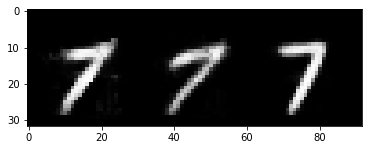

In [15]:
#Display image function
def imshow(image):    
    image = image.numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

images = next(iter(data_loader))

with torch.no_grad():
    encoded_images = encoder(images)
    reconstructed_images = decoder(encoded_images)

#Reconstructed images
print('Reconstructed Images:')
imshow(torchvision.utils.make_grid(reconstructed_images.view(batch_size, 1, 28, 28)))

# Denoising Autoencoder

In [ ]:
from skimage.util import random_noise

#Read in data
image_data = pd.read_csv("image_data.csv").values

for i in range(len(image_data)):
    image_data[i] = random_noise(image_data[i], mode = 's&p', amount = 0.1)

for i in range(3):
    plt.imshow(image_data[i].reshape(28, 28))
    plt.show()

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128, dtype = torch.float64)  #Linear layer 1
        self.fc2 = nn.Linear(128, output_dim, dtype = torch.float64) #Linear layer 2
        self.relu = nn.ReLU()  #ReLU activation function

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.relu(self.fc1(x))  #Apply ReLU activation after first linear layer
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128, dtype = torch.float64)  #Linear layer 1
        self.fc2 = nn.Linear(128, output_dim, dtype = torch.float64) #Linear layer 2
        self.sigmoid = nn.Sigmoid()  #Sigmoid activation function

    def forward(self, z):
        z = self.fc1(z)
        z = self.sigmoid(self.fc2(z))  #Sigmoid activation
        return z

#Parameters
input_dim = 28 * 28  #Size 28x28
output_dim = 25

#Encoder and decoder
encoder = Encoder(input_dim, output_dim)
decoder = Decoder(output_dim, input_dim)

lr = 0.001
batch_size = 3
epochs = 10

class Dataset(Dataset):
    def __init__(self, csv_file, transform = None):
        self.data = pd.read_csv(csv_file, dtype = "float64")
        self.transform = transform
        
        scaler = MinMaxScaler()
        self.data = scaler.fit_transform(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

csv_file = 'image_data.csv'

#Data to tensors
transform = torch.tensor

#Data
dataset = Dataset(csv_file, transform = transform)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = False)

#Optimizer and Loss
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = lr)

#Train
for epoch in range(epochs):
    running_loss = 0.0
    for data in data_loader:
        inputs = data 
        optimizer.zero_grad()
        encoded = encoder(inputs)
        decoded = decoder(encoded)
        loss = criterion(decoded, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader)}")
    
#Display image function
def imshow(image):     
    image = image.numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

images = next(iter(data_loader)) #something with this

with torch.no_grad():
    encoded_images = encoder(images)
    reconstructed_images = decoder(encoded_images)

#Reconstructed images
print('Reconstructed Images:')
imshow(torchvision.utils.make_grid(reconstructed_images.view(batch_size, 1, 28, 28)))